# Exploring and comparing the EC tower data with gridded datasets


## Load modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error

## Analysis parameters

In [88]:
path = '/g/data/os22/chad_tmp/NEE_modelling/results/training_data/Ali_training_data.csv'

## CO2 flux correlation matrices

In [89]:
df = pd.read_csv(path,index_col='time', parse_dates=True)

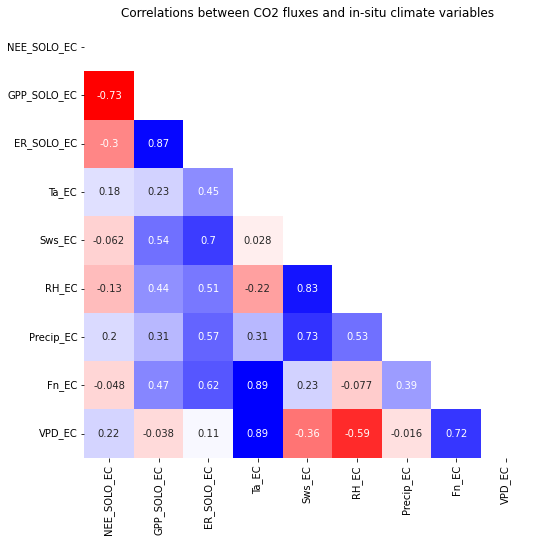

In [90]:
corr = df.filter(regex='EC').drop(['Fe_EC','Fh_EC','Fld_EC','Fsd_EC'],axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig,ax=plt.subplots(1,1, figsize=(8,8))
sb.heatmap(corr, cmap="bwr_r", annot=True, ax=ax, cbar=False, mask=mask)
plt.title('Correlations between CO2 fluxes and in-situ climate variables');

In [91]:
fluxes = df[['NEE_SOLO_EC', 'GPP_SOLO_EC','ER_SOLO_EC']]
rs = df.filter(regex='RS')

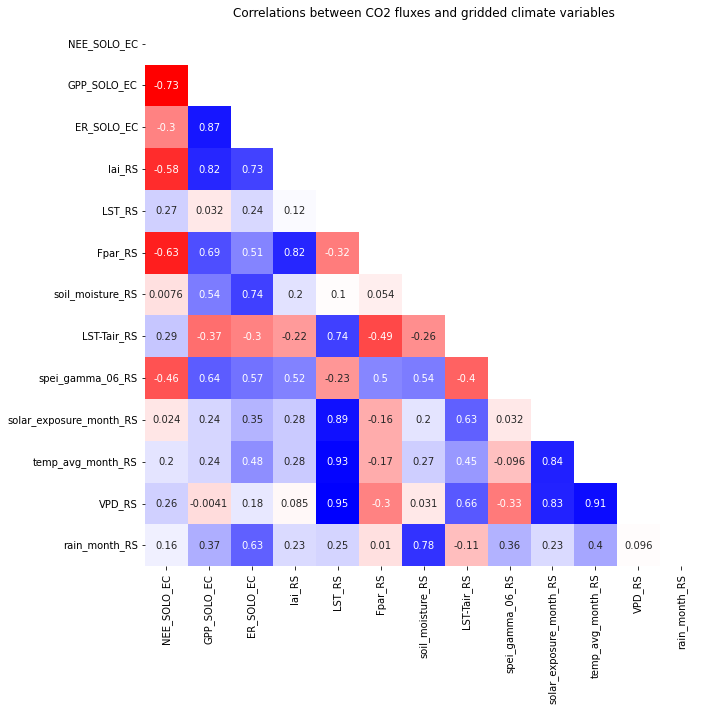

In [92]:
corr = fluxes.join(rs).drop(['rain_month_L1_RS','rain_month_L2_RS','rain_month_L3_RS'],axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig,ax=plt.subplots(1,1, figsize=(10,10))
sb.heatmap(corr, cmap="bwr_r", annot=True, ax=ax, cbar=False, mask=mask)
plt.title('Correlations between CO2 fluxes and gridded climate variables');

## Compare in-situ and gridded environmental variables

In [93]:
df.columns

Index(['NEE_SOLO_EC', 'GPP_SOLO_EC', 'ER_SOLO_EC', 'Ta_EC', 'Sws_EC', 'RH_EC',
       'Precip_EC', 'Fe_EC', 'Fh_EC', 'Fsd_EC', 'Fn_EC', 'Fld_EC', 'VPD_EC',
       'lai_RS', 'LST_RS', 'Fpar_RS', 'soil_moisture_RS', 'LST-Tair_RS',
       'spei_gamma_06_RS', 'solar_exposure_month_RS', 'temp_avg_month_RS',
       'VPD_RS', 'rain_month_RS', 'rain_month_L1_RS', 'rain_month_L2_RS',
       'rain_month_L3_RS'],
      dtype='object')

In [103]:
var_ec = 'Sws_EC'
var_rs = 'soil_moisture_RS'
var_name = 'VPD'

In [104]:
x=df[var_ec].values 
y=df[var_rs].values #dependent

mask = ~np.isnan(x) & ~np.isnan(y)
slope, intercept, r, p, sd, = stats.linregress(x[mask], y[mask])

mae = mean_absolute_error(x[mask],y[mask])

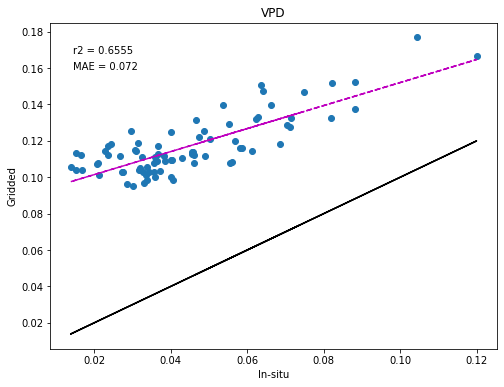

In [105]:
fig, ax = plt.subplots(1,1, sharey=True, figsize=(8,6))
plt.scatter(x, y)
plt.plot(x, intercept + slope * x, '--m')
plt.plot(x, x, '-k')
plt.text(np.nanmin(x*1.05),np.nanmax(y*0.95),"r2 = "+str(round(r**2,4)))
plt.text(np.nanmin(x*1.05),np.nanmax(y*0.90),"MAE = "+str(round(mae, 3)))
ax.set_ylabel('Gridded')
ax.set_xlabel('In-situ')
ax.set_title(var_name);